In [79]:
!pip install sqlalchemy
!pip install psycopg2-binary

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
from urllib.parse import quote_plus

# Connection parameters (DONT EVER PLACE CREDS IN A SCRIPT, THIS IS ONLY FOR TESTING)
db_type = ''
host = ''
dbname = ''
user = ''
password =  # safely escape @ symbol
port = ''

# Build connection string
conn_str = f'{db_type}://{user}:{password}@{host}:{port}/{dbname}'

# Create engine
engine = create_engine(conn_str)

# Test connection
with engine.connect() as conn:
    df_test = pd.read_sql("SELECT 1 AS test_connection", conn)

print(df_test)

   test_connection
0                1


In [65]:
#query = """
#SELECT
#    product_name_raw,
#    relevant_code_binary
#FROM cleaned_retailer_events
#WHERE relevant_code_binary IS NOT NULL
#"""


# 3. Execute the query and load into a DataFrame
#df_input = pd.read_sql_query(query, con=engine)
df_input = pd.read_csv("/Users/ramana/Documents/shopper_analysis/notebooks/1DataPrepInput/Dataprepinput_202504262252.csv")

# 4. Quick inspection
print(f"Total rows pulled: {len(df_input)}")
print(df_input.head())

Total rows pulled: 110000
                                    product_name_raw  relevant_code_binary
0  VECPIO Eco-Friendly Handcrafted Oversized Fair...                     0
1  Jacenvly Clothes For Baby Dolls 43 Cm Coat 18 ...                     1
2  FilterQueen Majestic Replacement Filter Kit, P...                     0
3  DYstyle 2Pack RGB Wireless Spotlight Spot Ligh...                     0
4  Cosplay.fm Women's Clown Costume Carnival Outf...                     0


In [66]:
import re

# Drop null product names (if any)
df_input = df_input.dropna(subset=['product_name_raw'])

# Drop exact duplicates
df_input = df_input.drop_duplicates(subset=['product_name_raw', 'relevant_code_binary'])

# Define a cleaning function
def clean_product_name(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep letters, numbers, space
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return text.strip()

# Apply cleaning
df_input['cleaned_product_name'] = df_input['product_name_raw'].apply(clean_product_name)

# Drop rows where cleaned name ends up empty (just in case)
df_input = df_input[df_input['cleaned_product_name'] != ""]

# Show a sample
df_input.head()

,product_name_raw,relevant_code_binary,cleaned_product_name
0,VECPIO Eco-Friendly Handcrafted Oversized Fair...,0,vecpio eco friendly handcrafted oversized fair...
1,Jacenvly Clothes For Baby Dolls 43 Cm Coat 18 ...,1,jacenvly clothes for baby dolls 43 cm coat 18 ...
2,"FilterQueen Majestic Replacement Filter Kit, P...",0,filterqueen majestic replacement filter kit pr...
3,DYstyle 2Pack RGB Wireless Spotlight Spot Ligh...,0,dystyle 2pack rgb wireless spotlight spot ligh...
4,Cosplay.fm Women's Clown Costume Carnival Outf...,0,cosplay fm women s clown costume carnival outf...


In [67]:
from sklearn.model_selection import train_test_split

# Make a safe copy of your cleaned and labeled data
df = df_input.copy()

# ---------------------------------------------
# Step 1: Split into 80% train and 20% temp (val+test)
# Stratify ensures class distribution (0 vs 1) is preserved in both splits
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,  # 20% held out for val + test
    stratify=df['relevant_code_binary'],
    random_state=42  # for reproducibility
)

print("Train set:", len(df_train))
print("Temp set (val + test):", len(df_temp))

# ---------------------------------------------
# Step 2: Split temp into 50% val and 50% test
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,  # Half of temp becomes test (so test is 10% of total)
    stratify=df_temp['relevant_code_binary'],
    random_state=42
)

print("Validation set:", len(df_val))
print("Test set:", len(df_test))

# ---------------------------------------------
# Step 3: Assign split labels to each set
df_train['split_type'] = 'train'
df_val['split_type'] = 'val'
df_test['split_type'] = 'test'

# ---------------------------------------------
# Step 4: Combine all splits back into a single dataframe
df_split = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# ---------------------------------------------
# Step 5: Check the split sizes
print("\nSplit distribution:")
print(df_split['split_type'].value_counts())

# ---------------------------------------------
# Step 6: Check class balance in each split
print("\nLabel distribution by split (raw counts):")
print(df_split.groupby('split_type')['relevant_code_binary'].value_counts())

print("\nLabel distribution by split (percentages):")
percentages = df_split.groupby('split_type')['relevant_code_binary'].value_counts(normalize=True).rename("percentage")
print(percentages)

Train set: 87997
Temp set (val + test): 22000
Validation set: 11000
Test set: 11000

Split distribution:
split_type
train    87997
val      11000
test     11000
Name: count, dtype: int64

Label distribution by split (raw counts):
split_type  relevant_code_binary
test        0                       10000
            1                        1000
train       0                       79997
            1                        8000
val         0                       10000
            1                        1000
Name: count, dtype: int64

Label distribution by split (percentages):
split_type  relevant_code_binary
test        0                       0.909091
            1                       0.090909
train       0                       0.909088
            1                       0.090912
val         0                       0.909091
            1                       0.090909
Name: percentage, dtype: float64


In [10]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 910.6 kB/s eta 0:00:00a 0:00:01


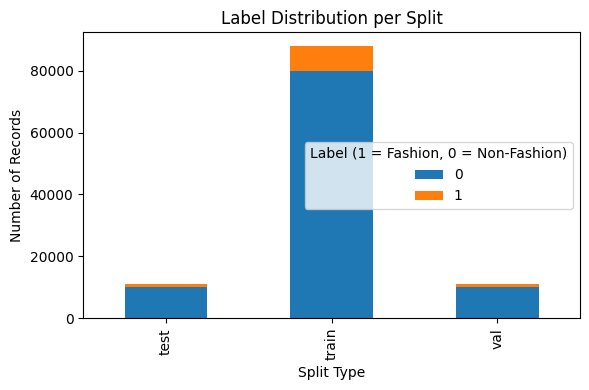

In [68]:
import matplotlib.pyplot as plt

# Count labels within each split
split_counts = df_split.groupby(['split_type', 'relevant_code_binary']).size().unstack()

# Plot stacked bar chart
split_counts.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Label Distribution per Split")
plt.xlabel("Split Type")
plt.ylabel("Number of Records")
plt.legend(title='Label (1 = Fashion, 0 = Non-Fashion)')
plt.tight_layout()
plt.show()

In [76]:
# Somewhere at the top of your notebook
current_iteration = 1

# When ready to insert
df_split['iteration'] = current_iteration

# Save to SQL
df_split.to_sql(
    'fashion_labeled_cleaned',
    engine,
    if_exists='append',
    index=False
)

# Print confirmation
print(f"Insert completed. Rows inserted: {len(df_split)}")

# Then manually increment for next time
current_iteration += 1

Insert completed. Rows inserted: 109997


In [78]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df_split.to_csv(f"/Users/ramana/Documents/shopper_analysis/notebooks/2TrainingInput/training_{timestamp}.csv", index=False)